In [9]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

In [10]:
def skull_strip_image(img_path, output_dir, kernel_size=5):
    """
    Performs skull stripping on a single preprocessed MRI image.

    Args:
        img_path (str): Path to the input preprocessed grayscale image.
        output_dir (str): Directory to save the resulting brain mask.
        kernel_size (int): Size of the kernel for morphological opening.
    """
    try:
        # --- Step 1: Load and Threshold ---
        img = cv2.imread(img_path, 0)
        if img is None:
            print(f"Warning: Could not read image {img_path}. Skipping.")
            return None, None # Return None for images to indicate failure

        # Apply Otsu's thresholding
        ret, thresh_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # --- Step 2: Clean with Morphology ---
        # Define kernel for morphological operations
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        # Apply morphological opening (erosion followed by dilation)
        opened_img = cv2.morphologyEx(thresh_img, cv2.MORPH_OPEN, kernel)

        # --- Step 3: Isolate Largest Component ---
        # Find connected components
        num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(opened_img, connectivity=8)

        # Find the label of the largest component (excluding background label 0)
        if num_labels <= 1: # Only background found
             print(f"Warning: No foreground components found after opening for {img_path}. Saving empty mask.")
             final_mask = np.zeros_like(opened_img) # Create an empty mask
        else:
            # Get areas of all components (excluding background at index 0)
            areas = stats[1:, cv2.CC_STAT_AREA]
            largest_label = 1 + np.argmax(areas) # Add 1 because we excluded the background

            # Create a mask containing only the largest component
            final_mask = np.zeros_like(opened_img)
            final_mask[labels_im == largest_label] = 255

        # --- Save the final mask ---
        filename = os.path.basename(img_path)
        output_path = os.path.join(output_dir, filename.replace('.png', '_brain_mask.png'))
        cv2.imwrite(output_path, final_mask)

        # Return images for potential visualization
        return img, thresh_img, opened_img, final_mask

    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None, None # Indicate failure

In [11]:
input_base_dir = '/content/drive/MyDrive/processed_images' # Folder containing tumor subfolders with preprocessed images
output_base_dir = '/content/drive/MyDrive/skull_stripped_masks' # Folder where brain masks will be saved
tumor_types = ['Meningioma', 'Glioma', 'Pituitary tumor'] # Match your folder names

# --- Process all images ---
all_results = {} # To store results for visualization later

for tumor_type in tumor_types:
    input_dir = os.path.join(input_base_dir, tumor_type)
    output_dir = os.path.join(output_base_dir, tumor_type)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created directory: {output_dir}")

    # Find all preprocessed image files
    search_pattern = os.path.join(input_dir, '*.png')
    # Make sure we don't accidentally process masks if they exist
    image_paths = [p for p in glob.glob(search_pattern) if '_mask' not in p]

    print(f"\nProcessing {len(image_paths)} images in '{input_dir}'...")

    for i, img_path in enumerate(image_paths):
        original, thresh, opened, final = skull_strip_image(img_path, output_dir)
        # Store results of the first image of each type for visualization
        if i == 0 and original is not None:
             all_results[tumor_type] = (original, thresh, opened, final, img_path)


print("\n✅ Skull stripping process complete for all images.")

Created directory: /content/drive/MyDrive/skull_stripped_masks/Meningioma

Processing 708 images in '/content/drive/MyDrive/processed_images/Meningioma'...
Created directory: /content/drive/MyDrive/skull_stripped_masks/Glioma

Processing 1426 images in '/content/drive/MyDrive/processed_images/Glioma'...
Created directory: /content/drive/MyDrive/skull_stripped_masks/Pituitary tumor

Processing 930 images in '/content/drive/MyDrive/processed_images/Pituitary tumor'...

✅ Skull stripping process complete for all images.



Generating visualizations...


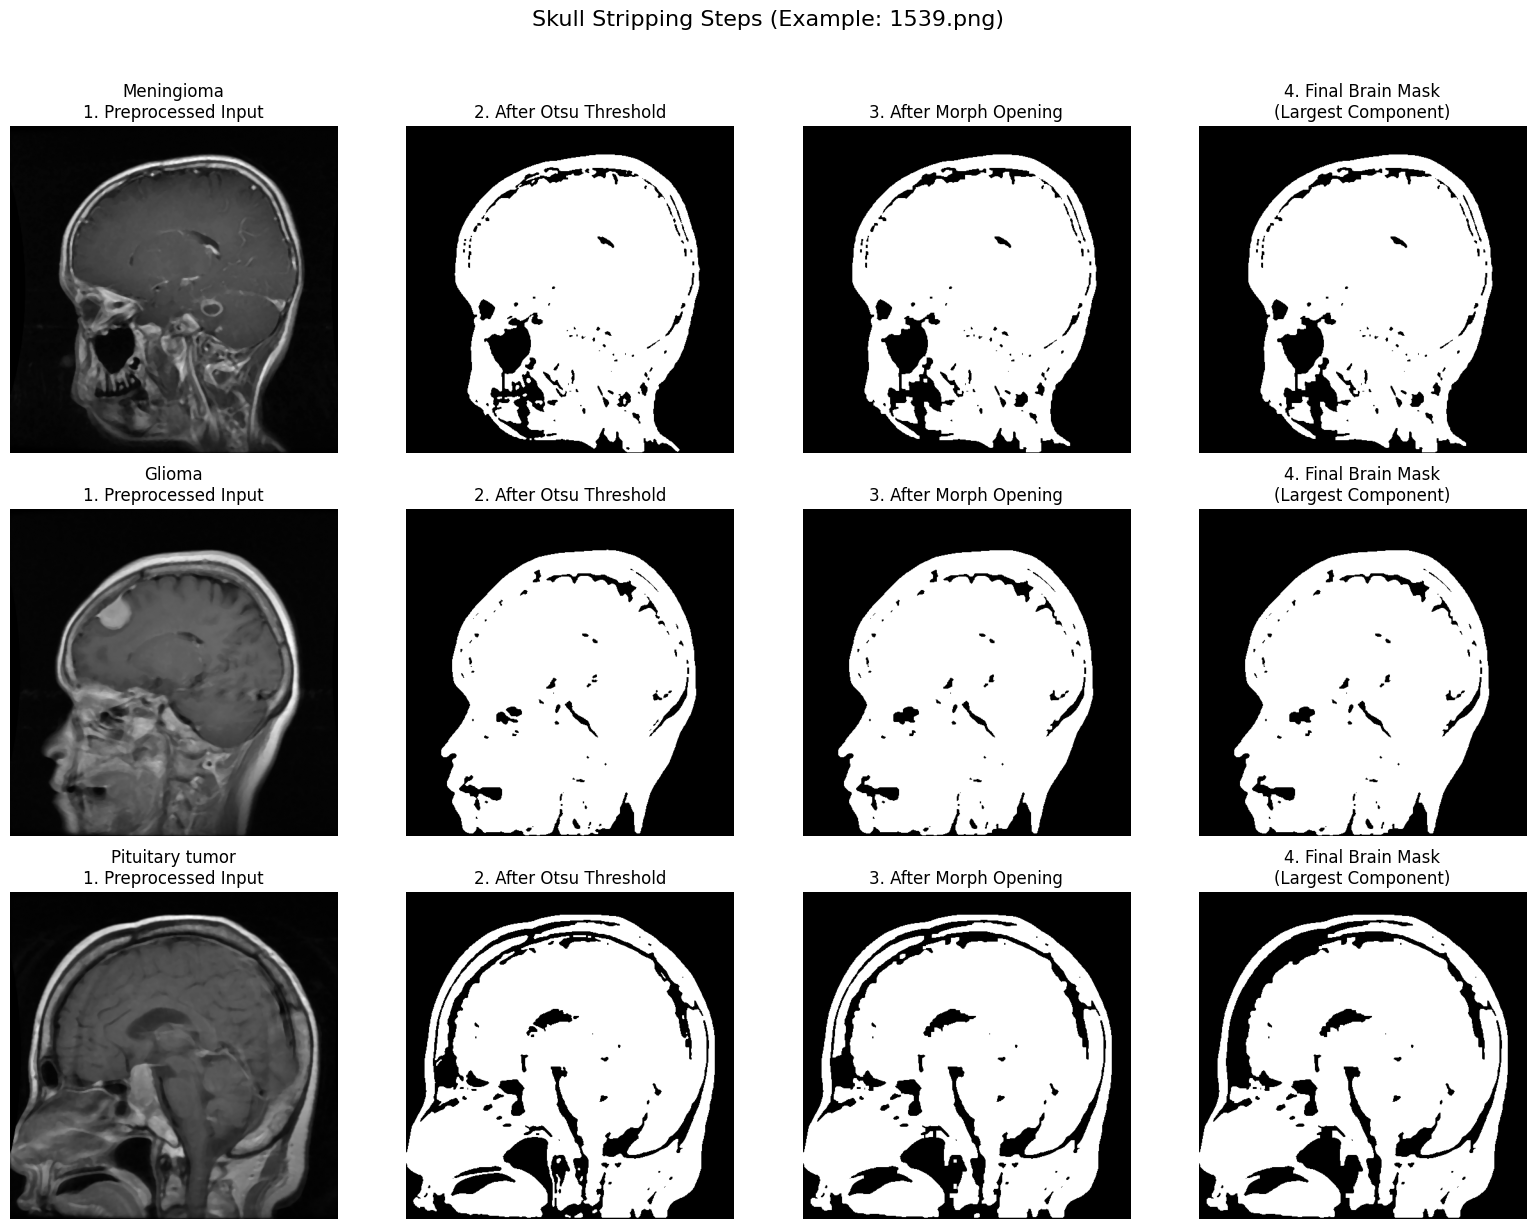

In [12]:
print("\nGenerating visualizations...")
num_types = len(all_results)
if num_types > 0:
    fig, axes = plt.subplots(num_types, 4, figsize=(16, 4 * num_types)) # 4 columns: Original, Otsu, Opened, Final Mask

    # Adjust layout if only one tumor type is processed
    if num_types == 1:
        axes = axes.reshape(1, -1) # Make it 2D for consistent indexing

    type_idx = 0
    for tumor_type, (original, thresh, opened, final, img_path) in all_results.items():
        fig.suptitle(f"Skull Stripping Steps (Example: {os.path.basename(img_path)})", y=1.02, fontsize=16) # Add overall title if needed

        axes[type_idx, 0].imshow(original, cmap='gray')
        axes[type_idx, 0].set_title(f'{tumor_type}\n1. Preprocessed Input')
        axes[type_idx, 0].axis('off')

        axes[type_idx, 1].imshow(thresh, cmap='gray')
        axes[type_idx, 1].set_title('2. After Otsu Threshold')
        axes[type_idx, 1].axis('off')

        axes[type_idx, 2].imshow(opened, cmap='gray')
        axes[type_idx, 2].set_title('3. After Morph Opening')
        axes[type_idx, 2].axis('off')

        axes[type_idx, 3].imshow(final, cmap='gray')
        axes[type_idx, 3].set_title('4. Final Brain Mask\n(Largest Component)')
        axes[type_idx, 3].axis('off')

        type_idx += 1

    plt.tight_layout()
    plt.show()
else:
    print("No images were successfully processed for visualization.")

In [13]:
import shutil

# Define the path to the directory containing the skull-stripped masks
output_base_dir = '/content/drive/MyDrive/skull_stripped_masks'
zip_output_path = '/content/skull_stripped_masks.zip'

# Create a zip archive of the directory
try:
    shutil.make_archive(zip_output_path.replace('.zip', ''), 'zip', output_base_dir)
    print(f"Successfully created zip file at: {zip_output_path}")
except Exception as e:
    print(f"Error creating zip file: {e}")

Successfully created zip file at: /content/skull_stripped_masks.zip


In [14]:
from google.colab import files

try:
    files.download(zip_output_path)
except Exception as e:
    print(f"Error downloading file: {e}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>